<a href="https://colab.research.google.com/github/kirath2205/Final-Year-Project/blob/main/defensive_distillation_inception_cifar100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, UpSampling2D, Flatten, BatchNormalization, Dense, Dropout, GlobalAveragePooling2D , UpSampling3D , Lambda
from tensorflow.keras import optimizers
from keras.datasets import cifar100,cifar10,fashion_mnist
import tensorflow as tf
from keras.utils import np_utils
import matplotlib.pyplot as plt
import time
from skimage.transform import resize
from keras import applications
from tensorflow.keras.applications.resnet50 import ResNet50 , preprocess_input , decode_predictions
from keras.preprocessing.image import ImageDataGenerator
tf.keras.backend.clear_session()

In [56]:
class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.2,
        temperature=20,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

    def call(self, inputs, *args, **kwargs):
       return self.student(inputs)

In [57]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [58]:
def select_dataset(index=1): #1 for cifar10 , 2 for cifar100 , 3 for fashion mnist
  if(index == 1):
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    channel = 3
    num_classes = 10
  if(index == 2):
    (x_train, y_train), (x_test, y_test) = cifar100.load_data()
    num_classes = 100
    channel = 3
  if(index == 3):
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    x_train = x_train.reshape((60000, 28, 28, 1))
    x_test =  x_test.reshape((10000, 28, 28, 1))
    num_classes = 10
    y_train = np_utils.to_categorical(y_train, num_classes)
    y_test = np_utils.to_categorical(y_test, num_classes)
    channel = 1
    return (x_train , y_train , x_test , y_test , num_classes , channel)

  #Pre-process the data
  x_train = preprocess_input(x_train)
  x_test = preprocess_input(x_test)

  datagen = ImageDataGenerator(preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=True))
  datagen.fit(x_train)
  y_train = np_utils.to_categorical(y_train, num_classes)
  y_test = np_utils.to_categorical(y_test, num_classes)

  return (x_train , y_train , x_test , y_test , num_classes , channel , datagen)

In [45]:
index = 1
x_train , y_train , x_test , y_test , num_classes ,channel , datagen = select_dataset(index)
model_name = 'desktop/Trained_models/defensive_distillation_keras_resnet50_cifar10'
model_path = 'desktop/Trained_models/defensive_distillation_keras_resnet50_cifar10.h5'

In [59]:
index = 2
x_train , y_train , x_test , y_test , num_classes ,channel , datagen = select_dataset(index)
model_name = 'desktop/Trained_models/defensive_distillation_keras_resnet50_cifar100'
model_path = 'desktop/Trained_models/defensive_distillation_keras_resnet50_cifar100.h5'

In [60]:
temp = 200
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in resnet_model.layers:
    if isinstance(layer, BatchNormalization):
      layer.trainable = True
    else:
      layer.trainable = False
if(index==1):
  teacher = keras.Sequential(
      [
        layers.UpSampling2D((7,7)),
        resnet_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256),
        layers.ReLU(),
        layers.Dropout(0.25),
        layers.BatchNormalization(),
        layers.Dense(32),
        layers.ReLU(),
        layers.Dropout(0.1),
        layers.BatchNormalization(),
        layers.Dense(num_classes),
        layers.Lambda((lambda x: x / temp)),
      ],
      name="teacher",
  )

# Create the student
  student = keras.Sequential(
      [
        layers.UpSampling2D((7,7)),
        resnet_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256),
        layers.ReLU(),
        layers.Dropout(0.25),
        layers.BatchNormalization(),
        layers.Dense(32),
        layers.ReLU(),
        layers.Dropout(0.1),
        layers.BatchNormalization(),
        layers.Dense(num_classes),
        layers.Lambda((lambda x: x / temp)),
      ],
      name="student",
  )
else:
  teacher = keras.Sequential(
      [
        layers.UpSampling2D((7,7)),
        resnet_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1024),
        layers.ReLU(),
        layers.Dropout(0.3),
        layers.BatchNormalization(),
        layers.Dense(512),
        layers.ReLU(),
        layers.BatchNormalization(),
        layers.Dense(256),
        layers.ReLU(),
        layers.BatchNormalization(),
        layers.Dense(num_classes),
        layers.Lambda((lambda x: x / temp)),
      ],
      name="teacher",
  )

# Create the student
  student = keras.Sequential(
      [
        layers.UpSampling2D((7,7)),
        resnet_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1024),
        layers.ReLU(),
        layers.Dropout(0.3),
        layers.BatchNormalization(),
        layers.Dense(512),
        layers.ReLU(),
        layers.BatchNormalization(),
        layers.Dense(256),
        layers.ReLU(),
        layers.BatchNormalization(),
        layers.Dense(num_classes),
        layers.Lambda((lambda x: x / temp)),
      ],
      name="student",
  )



In [61]:
epochs = 50
callbacks = [ 
    tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_accuracy', verbose=1, save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau( factor = 0.7, patience = 5, min_lr = 0.000001, verbose = 1 ), #patience = 7 and 20 for cifar-100 , patience = 5 and 10 for cifar-10
    #tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy' , patience = 10)
  ]
batch_size = 128
teacher.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.CategoricalAccuracy()],
)

# Train and evaluate teacher on data.
history_teacher = teacher.fit_generator(datagen.flow(x_train, y_train,
                                  batch_size=batch_size),
                                  steps_per_epoch=x_train.shape[0] // batch_size,
                                  epochs=epochs,
                                  validation_data=(x_test, y_test))
teacher.evaluate(x_test, y_test)

Epoch 1/50
390/390 [==============================] - 164s 421ms/step - loss: 4.4183 - categorical_accuracy: 0.3364 - val_loss: 4.0000 - val_categorical_accuracy: 0.4553
Epoch 2/50
390/390 [==============================] - 165s 424ms/step - loss: 3.7556 - categorical_accuracy: 0.4518 - val_loss: 3.1809 - val_categorical_accuracy: 0.5155
Epoch 3/50
390/390 [==============================] - 166s 426ms/step - loss: 2.9111 - categorical_accuracy: 0.5153 - val_loss: 2.3685 - val_categorical_accuracy: 0.5747
Epoch 4/50
390/390 [==============================] - 166s 426ms/step - loss: 2.1607 - categorical_accuracy: 0.5938 - val_loss: 1.7630 - val_categorical_accuracy: 0.6687
Epoch 5/50
390/390 [==============================] - 166s 426ms/step - loss: 1.6406 - categorical_accuracy: 0.6588 - val_loss: 1.3893 - val_categorical_accuracy: 0.6957
Epoch 6/50
390/390 [==============================] - 166s 425ms/step - loss: 1.3033 - categorical_accuracy: 0.7007 - val_loss: 1.1179 - val_categoric

[0.7920945882797241, 0.8047000169754028]

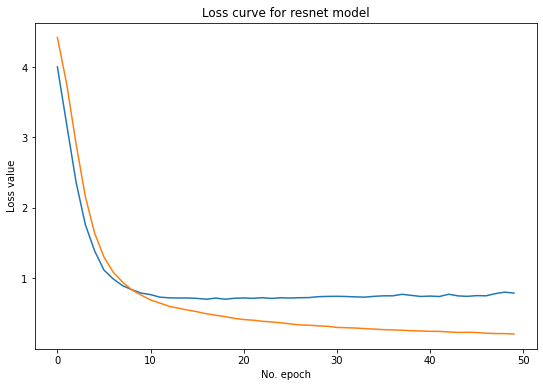

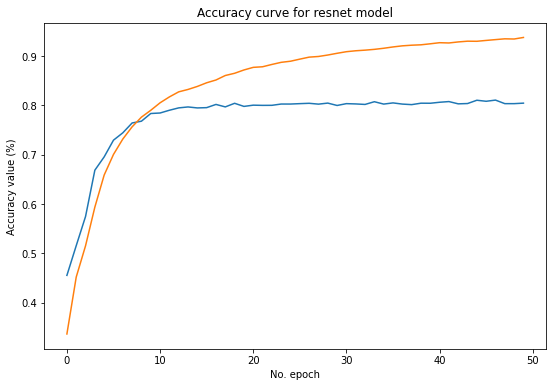

In [64]:

import matplotlib.pyplot as plt

plt.figure(figsize = (9,6))
plt.plot(history_teacher.history['val_loss'],label='Test loss')
plt.plot(history_teacher.history['loss'],label='Train loss')
plt.title('Loss curve for resnet model')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.show()

# Plot history: Accuracy
plt.figure(figsize = (9,6))
plt.plot(history_teacher.history['val_categorical_accuracy'],label = 'Test accuracy')
plt.plot(history_teacher.history['categorical_accuracy'],label = 'Train accuracy')
plt.title('Accuracy curve for resnet model')
plt.ylabel('Accuracy value (%)')
plt.xlabel('No. epoch')
plt.show()


In [65]:
distiller = Distiller(student=student, teacher=teacher)
distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.CategoricalAccuracy()],
    student_loss_fn=keras.losses.CategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.2,
    temperature=200,
)

# Distill teacher to student
history_distiller = distiller.fit_generator(datagen.flow(x_train, y_train,
                                  batch_size=batch_size),
                                  steps_per_epoch=x_train.shape[0] // batch_size,
                                  epochs=epochs,
                                  validation_data=(x_test, y_test),
                                  callbacks = callbacks)

# Evaluate student on test dataset
distiller.evaluate(x_test, y_test)

Epoch 1/50
390/390 [==============================] - 228s 584ms/step - categorical_accuracy: 0.7001 - student_loss: 3.5454 - distillation_loss: 6.5296e-05 - val_categorical_accuracy: 0.7060 - val_student_loss: 3.0231 - lr: 0.0010
Epoch 2/50
390/390 [==============================] - 226s 581ms/step - categorical_accuracy: 0.7230 - student_loss: 2.6822 - distillation_loss: 5.7412e-05 - val_categorical_accuracy: 0.7193 - val_student_loss: 2.1902 - lr: 0.0010
Epoch 3/50
390/390 [==============================] - 226s 580ms/step - categorical_accuracy: 0.7547 - student_loss: 1.8275 - distillation_loss: 4.9643e-05 - val_categorical_accuracy: 0.7512 - val_student_loss: 1.3563 - lr: 0.0010
Epoch 4/50
390/390 [==============================] - 226s 580ms/step - categorical_accuracy: 0.7843 - student_loss: 1.2467 - distillation_loss: 4.3505e-05 - val_categorical_accuracy: 0.7700 - val_student_loss: 1.2082 - lr: 0.0010
Epoch 5/50
390/390 [==============================] - 226s 580ms/step - cate

0.8083999752998352

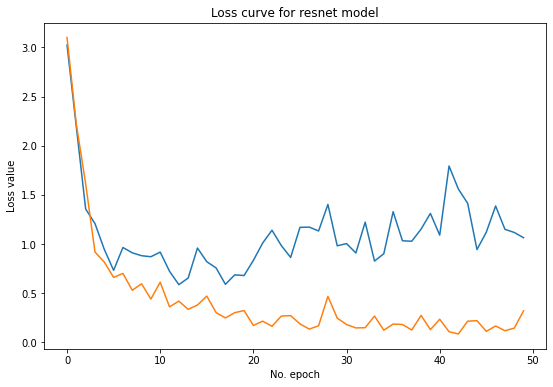

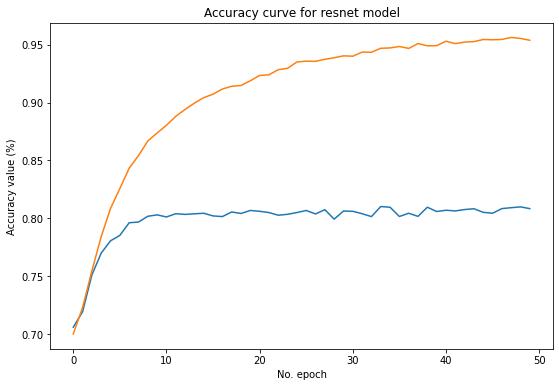

In [66]:

import matplotlib.pyplot as plt

plt.figure(figsize = (9,6))
plt.plot(history_distiller.history['val_student_loss'],label='Test loss')
plt.plot(history_distiller.history['student_loss'],label='Train loss')
plt.title('Loss curve for resnet model')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.show()

# Plot history: Accuracy
plt.figure(figsize = (9,6))
plt.plot(history_distiller.history['val_categorical_accuracy'],label = 'Test accuracy')
plt.plot(history_distiller.history['categorical_accuracy'],label = 'Train accuracy')
plt.title('Accuracy curve for resnet model')
plt.ylabel('Accuracy value (%)')
plt.xlabel('No. epoch')
plt.show()


In [67]:


def make_prediction(model , image , true_value):
  true_label_index = -1
  for i in range(len(true_value)):

    if(true_value[i]==1):
      true_label_index = i
      break

  prediction = model.predict(image)[0]
  probability = float('-inf')
  predicted_label_index = -1

  for i in range(len(prediction)):

    if(prediction[i]>probability):
      probability = prediction[i]
      predicted_label_index = i

  if(true_label_index!=predicted_label_index):
    return 1
  return 0



In [68]:
import keras,os
import tensorflow as tf
from keras.models import Sequential,Model
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D , Dropout
import numpy as np
from tensorflow import keras
from keras.initializers import glorot_uniform
from keras import applications
from tensorflow.keras.applications.resnet50 import ResNet50 , preprocess_input
from keras import regularizers
from absl import app, flags

# Install bleeding edge version of cleverhans
!pip install git+https://github.com/tensorflow/cleverhans.git#egg=cleverhans
from cleverhans.tf2.attacks.projected_gradient_descent import projected_gradient_descent
from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [69]:
from keras.preprocessing.image import img_to_array

epsilon_end = 0.8
#logits_model = tf.keras.Model(model.input,model.layers[-1].output)
total_images = 200

result={}
epsilon = 0.1
while(epsilon <= epsilon_end):

  fgsm_counter = 0
  pgd_counter = 0
  print("Epsilon value - ",epsilon)
  print()
  for image_index in range(total_images):
  
  
    image = x_test[image_index]
    image = img_to_array(image)
    image = image.reshape(1, 32, 32, 3)
    true_value = y_test[image_index]
    original_prediction = make_prediction(distiller,image,true_value)
    fgsm_sample = fast_gradient_method(distiller, image, epsilon, np.inf, targeted=False)
    pgd_sample = projected_gradient_descent(distiller, image, epsilon, 0.01, 40, np.inf)
    print(epsilon,' ',image_index)
    fgsm_prediction = make_prediction(distiller , fgsm_sample , true_value)
    pgd_prediction = make_prediction(distiller , pgd_sample , true_value)
    pgd_counter+=pgd_prediction
    fgsm_counter+=fgsm_prediction
    print(pgd_counter,' ',fgsm_counter)
  result[epsilon] = (fgsm_counter , pgd_counter)
  epsilon+=0.1


Epsilon value -  0.1

0.1   0
1   1
0.1   1
2   2
0.1   2
3   3
0.1   3
3   3
0.1   4
3   3
0.1   5
4   4
0.1   6
4   4
0.1   7
5   5
0.1   8
6   6
0.1   9
6   6
0.1   10
7   7
0.1   11
7   7
0.1   12
7   7
0.1   13
7   7
0.1   14
7   7
0.1   15
7   7
0.1   16
7   7
0.1   17
7   7
0.1   18
7   7
0.1   19
7   7
0.1   20
7   7
0.1   21
7   7
0.1   22
7   7
0.1   23
7   7
0.1   24
7   7
0.1   25
7   7
0.1   26
7   7
0.1   27
7   7
0.1   28
7   7
0.1   29
8   8
0.1   30
8   8
0.1   31
8   8
0.1   32
8   8
0.1   33
9   9
0.1   34
9   9
0.1   35
10   10
0.1   36
10   10
0.1   37
11   11
0.1   38
11   11
0.1   39
11   11
0.1   40
12   12
0.1   41
12   12
0.1   42
13   13
0.1   43
13   13
0.1   44
13   13
0.1   45
13   13
0.1   46
13   13
0.1   47
13   13
0.1   48
14   14
0.1   49
14   14
0.1   50
14   14
0.1   51
14   14
0.1   52
14   14
0.1   53
14   14
0.1   54
14   14
0.1   55
14   14
0.1   56
14   14
0.1   57
15   15
0.1   58
15   15
0.1   59
15   15
0.1   60
15   15
0.1   61
16   16
0.1 

In [70]:
for key in result.keys():
  print(key,' ',result[key])

0.1   (49, 52)
0.2   (72, 88)
0.30000000000000004   (87, 109)
0.4   (98, 118)
0.5   (106, 118)
0.6   (112, 118)
0.7   (114, 118)
0.7999999999999999   (115, 118)
